## 0. Introduction 

In this machine learning project, I aim to analyze the diabetes dataset, which contains baseline measurements and disease progression data for 442 diabetes patients. I will apply linear regression techniques, including univariate and multivariate regression, to predict the quantitative measure of disease progression based on the available variables. Additionally, I will explore the concepts of underfitting, overfitting, and regularization to improve the model's performance and prevent overfitting.

In [2183]:
import torch
from torch import nn
from sklearn import model_selection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline


In [2184]:
diabetes_db = pd.read_csv('https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt', sep='\t', header=0)
#sn.pairplot(diabetes_db)


In [2185]:
diabetes_db.head(10)
diabetes_db.describe()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,4.641411,91.260181,152.133484
std,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,0.522391,11.496335,77.093005
min,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000,25.000000
25%,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,83.250000,87.000000
50%,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000,140.500000
75%,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,98.000000,211.500000
max,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000,346.000000


In [2186]:
plt.figure(figsize=(15, 3))

<Figure size 1080x216 with 0 Axes>

<Figure size 1080x216 with 0 Axes>

We first split the data into test and training sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [2187]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    diabetes_db.loc[:, diabetes_db.columns != 'Y'],
    diabetes_db['Y'],
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).float()
y_train = y_train.reshape(-1, 1)
y_test = torch.from_numpy(y_test.values).float()
y_test = y_test.reshape(-1, 1)


We can see that all the independent variables are on different scales. This can affect gradient descent, we therefore need to normalize all features to zero mean, and unit standard deviation. The normalized value $z_i$ of $x_i$ is obtained through $z_i = \frac{x_i - μ}{σ}$ where $μ$ is the mean and $σ$ is the standard deviation of $X$ and $x_i, μ, σ ∈ \mathbb{R}^D$.

**Q1.** Complete the method and normalize `x_train, x_test` [2 marks]

In [2188]:
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
    # Adding a small Offset to the denominator to prevent divide by zero exception
    offset = 1e-6
    x_std_features = (x - mu) / (sigma + offset)
    return x_std_features

# your code here
x_train_dimensions = list(range(x_train.dim() - 1))
x_train_mean = torch.mean(x_train, dim=x_train_dimensions)
x_train_std = torch.std(x_train, dim=x_train_dimensions)
x_train = norm_set(x_train, x_train_mean, x_train_std)

x_test_dimensions = list(range(x_test.dim() - 1))
x_test_mean = torch.mean(x_test, dim=x_test_dimensions)
x_test_std = torch.std(x_test, dim=x_test_dimensions)
x_test = norm_set(x_test, x_test_mean, x_test_std)
print("Normalised x_train",x_train)
print("Normalised x_test", x_test)


Normalised x_train tensor([[ 1.4962,  1.0599,  0.2196,  ...,  0.7100,  0.5467, -0.0614],
        [-0.2285,  1.0599, -0.4188,  ...,  1.4822, -0.0197,  0.3667],
        [ 0.0851, -0.9408,  1.0175,  ..., -0.0621,  0.3308, -0.3182],
        ...,
        [ 0.6339, -0.9408, -0.4644,  ..., -0.8343, -0.2534, -0.0614],
        [-0.3069, -0.9408, -0.5328,  ..., -0.0621, -0.8295, -0.8319],
        [-2.0317, -0.9408,  0.5616,  ..., -0.8343, -0.1329, -0.0614]])
Normalised x_test tensor([[ 0.9764, -0.9190,  0.0139, -0.2571,  2.6045,  2.5574,  0.3058,  0.7590,
          0.7972,  0.0519],
        [ 1.8794, -0.9190,  0.9007,  0.6029, -0.5761, -0.4162, -0.0630, -0.8055,
         -0.3786, -0.3252],
        [ 1.3237,  1.0759,  0.0583, -0.1789,  2.1377,  0.9557,  1.0433, -0.0233,
          1.9112, -0.2310],
        [ 1.9488, -0.9190,  1.2110,  1.9063,  1.1164,  0.6997, -1.6118,  3.0275,
          2.2141,  1.5606],
        [ 0.3512,  1.0759, -0.2742,  0.0556,  0.7662,  1.0476, -0.2105,  0.7590,
         -0.

## 1.1 Linear Regression

We will building the linear regression model in pytorch using a custom layer. 

Refering back to the lecture notes, we define $ y = f(x) = w^T x$, so we need to learn weight vector $w$.

**Q2.** Fill in the forward method of the LinearRegression class. [2 marks]

In [2189]:
class LinearRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)
    self.linear = nn.Linear(num_features, 1)
  
  def forward(self, x):
    y = 0
   ### your code here
    y = torch.matmul(x,self.weight.T) 
    return y


As we need to account for the bias, we add a column of ones to the `x_data`

In [2190]:
# add a feature for bias
x_train = torch.cat([x_train, torch.ones(x_train.shape[0], 1)], dim=1)
x_test = torch.cat([x_test, torch.ones(x_test.shape[0], 1)], dim=1)

In [2191]:
#test the custom layer
model = LinearRegression(x_train.shape[1])
prediction = model(x_train)
prediction.shape # the output should be Nx1

torch.Size([353, 1])

The next step is to calculate the cost. For this we will use the mean squared error $E(w) = \frac{1}{N} Σ_{i=0}^N (f(x_i) - y_i)^2$

**Q3.** Fill in the method to calculate the squared error of for any set of labels $y$ and predictions [2 marks]

In [2192]:
def mean_squared_error(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
  ### your code here
#   cost = torch.mean((y_pred - y_true)**2)
  sq_error = (y_pred - y_true)**2
  N = len(y_pred)
  cost = 1.0/(N) * sq_error.sum()
  return cost

In [2193]:
cost = mean_squared_error(y_train, prediction)
print("Mean Squared Error: ",cost)

Mean Squared Error:  tensor(29711.3223)


We see that using a random set of initial parameters for bias and weight, yields a relatively high error. As such, we will update the values for $w$ using gradient descent. We will implement a custom method for gradient descent.

**Q4.** In the method below, add your code to update bias and weight using learning rate $α$. [2 marks]

First you need to calculate the partial derivative of the loss function with respect to the weights. 

We then update the weights vector using the following equation:

$ weight = weight - α * ∂_{weight}$

In [2194]:
def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float) -> None:
  weight = model.weight
  N = X.shape[0]
  x_dimensions = list(range(X.dim() - 1))
  meansq_error = mean_squared_error(y, y_pred)
  derivate_error = 2*(y_pred - y)
  derivate_weight = torch.mean(derivate_error * X, dim=x_dimensions)
  weight = weight - lr * derivate_weight
  model.weight = nn.Parameter(weight, requires_grad=False)

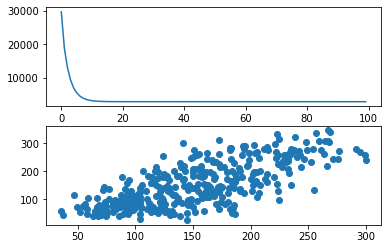

Parameter containing:
tensor([[  1.9400, -11.4488,  26.3048,  16.6306,  -9.8810,  -2.3180,  -7.6995,
           8.2121,  21.9769,   2.6065, 153.7365]])
Minimum cost: 2890.406494140625


In [2195]:
cost_lst = list()
model = LinearRegression(x_train.shape[1])
alpha = .1
for it in range(100):
  prediction = model(x_train)
  cost = mean_squared_error(y_train, prediction)
  cost_lst.append(cost)
  gradient_descent_step(model, x_train, y_train, prediction, alpha)
fig, axs = plt.subplots(2)
axs[0].plot(list(range(it+1)), cost_lst)
axs[1].scatter(prediction, y_train)
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

<font color="maroon">**Q5.** What conclusion if any can be drawn from the weight values? How does gender and BMI affect blood sugar levels?

What are the estimated blood sugar levels for the below examples? [2 marks] </font>

| AGE | SEX | BMI | BP  | S1  | S2    | S3 | S4  | S5     | S6  |
|-----|-----|-----|-----|-----|-------|----|-----|--------|-----|
| 25  | F   | 18  | 79  | 130 | 64.8  | 61 | 2   | 4.1897 | 68  |
| 50  | M   | 28  | 103 | 229 | 162.2 | 60 | 4.5 | 6.107  | 124 |

In [2196]:
### your code here
model.weight
examples = torch.Tensor([[25, 2, 18, 79, 130, 64.8, 61, 2, 4.1897, 68],
                                 [50, 1, 28, 103, 229, 162.2, 60, 4.5, 6.107, 124]])
examples_dimensions = list(range(examples.dim() - 1))
examples_mean = torch.mean(examples, dim=examples_dimensions)
examples_std = torch.std(examples, dim=examples_dimensions)
examples = (examples - examples_mean)/examples_std

examples = torch.hstack((examples, torch.ones(2,1)))

prediction = model(examples)
print("Weights",model.weight)
print("Predicted Blood Sugar Levels are: ", prediction)

Weights Parameter containing:
tensor([[  1.9400, -11.4488,  26.3048,  16.6306,  -9.8810,  -2.3180,  -7.6995,
           8.2121,  21.9769,   2.6065, 153.7365]])
Predicted Blood Sugar Levels are:  tensor([[ 93.9010],
        [213.5721]])


Now estimate the error on the test set. Is the error on the test set comparable to that of the train set? What can be said about the fit of the model? When does a model over/under fits?


In [2197]:
### your code here
prediction = model(x_test)
test_error = mean_squared_error(y_test, prediction)
print("Train Error is ", min(cost_lst))
print("Test Error is ",test_error)
## 

Train Error is  tensor(2890.4065)
Test Error is  tensor(2929.9824)


- The errors on the train set and the test set are comparable. The model is slightly underfitting, as the error on test data is just slightly more than the train data.

<font color="maroon">**Q6.** Try the code with a number of learning rates that differ by orders of magnitude and record the error of the training and test sets. What do you observe on the training error? What about the error on the test set? [3 marks]</font>

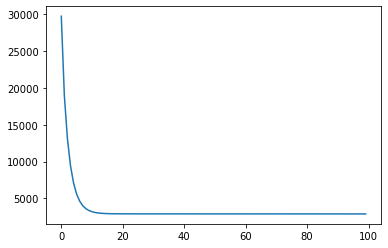

Minimum cost for the selected alpha is 0.1: 2890.406494140625
Minimum Train Error for 0.1 learning rate are : 2890.406494140625
Test Error for 0.1 learning rate are : 2929.982421875


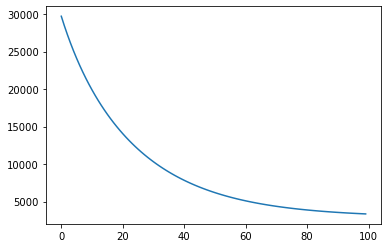

Minimum cost for the selected alpha is 0.1: 3356.77783203125
Minimum Train Error for 0.01 learning rate are : 3356.77783203125
Test Error for 0.01 learning rate are : 3005.350830078125


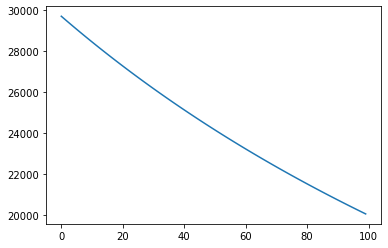

Minimum cost for the selected alpha is 0.1: 20040.5859375
Minimum Train Error for 0.001 learning rate are : 20040.5859375
Test Error for 0.001 learning rate are : 17473.318359375


In [2198]:
learning_rates = [0.1,0.01,0.001]
for lr in learning_rates:
    cost_lst = list()
    model = LinearRegression(x_train.shape[1])
    for itr in range(100):
        prediction = model(x_train)
        cost = mean_squared_error(y_train, prediction)
        cost_lst.append(cost)
        gradient_descent_step(model, x_train, y_train, prediction, lr)
    fig, axs = plt.subplots()
    axs.plot(list(range(itr+1)), cost_lst)
#     axs[1].scatter(prediction, y_train)
    plt.show()
    prediction = model(x_test)
    test_error = mean_squared_error(y_test, prediction)
    print('Minimum cost for the selected alpha is {}: {}'.format(alpha, min(cost_lst)))
    print('Minimum Train Error for {} learning rate are : {}'.format(lr,min(cost_lst)))
    print('Test Error for {} learning rate are : {}'.format(lr,test_error))

# 1.2 Regularized Linear Regression
In this exercise, we will be trying to create a model that fits data that is clearly not linear. We will be attempting to fit the data points seen in the graph below:

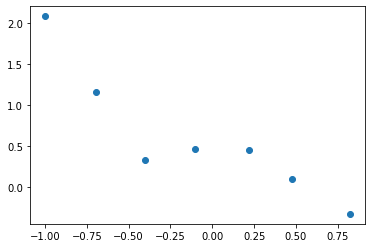

In [2199]:
x = torch.tensor([-0.99768, -0.69574, -0.40373, -0.10236, 0.22024, 0.47742, 0.82229])
y = torch.tensor([2.0885, 1.1646, 0.3287, 0.46013, 0.44808, 0.10013, -0.32952]).reshape(-1, 1)
plt.scatter(x, y)
plt.show()

In order to fit this data we will create a new hypothesis function, which uses a fifth-order polynomial:

$
 h_{\theta}(x) = \theta_{0} x_{0} + \theta_{1} x_{1} + \theta_{2} x_{1} ^2 + \theta_{3} x_{1} ^3 + \theta_{4} x_{1} ^4 + \theta_{5} x_{1} ^5
$

As we are fitting a small number of points with a high order model, there is a danger of overfitting.  \\

To attempt to avoid this we will use regularization. Our cost function becomes:

$
 J(\theta) = \frac{1}{2m}  \left[ \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})^2 + \lambda    \sum_{j=1}^n \theta_{j}^2 \right] 
$

Adjust variable `x` to include the higher order polynomials

In [2200]:
### your code here
x = torch.stack([torch.ones(x.shape),x, x**2, x**3, x**4, x**5])
print(x.size())
print(x)
### hint: remember to add x_0 for the bias

torch.Size([6, 7])
tensor([[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
          1.0000e+00,  1.0000e+00],
        [-9.9768e-01, -6.9574e-01, -4.0373e-01, -1.0236e-01,  2.2024e-01,
          4.7742e-01,  8.2229e-01],
        [ 9.9537e-01,  4.8405e-01,  1.6300e-01,  1.0478e-02,  4.8506e-02,
          2.2793e-01,  6.7616e-01],
        [-9.9306e-01, -3.3678e-01, -6.5807e-02, -1.0725e-03,  1.0683e-02,
          1.0882e-01,  5.5600e-01],
        [ 9.9075e-01,  2.3431e-01,  2.6568e-02,  1.0978e-04,  2.3528e-03,
          5.1952e-02,  4.5719e-01],
        [-9.8845e-01, -1.6302e-01, -1.0726e-02, -1.1237e-05,  5.1818e-04,
          2.4803e-02,  3.7595e-01]])


**Q7.** Update the cost and gradient descent methods to use the regularised cost, as shown above. [4 marks]

Note that the punishment for having more terms is not applied to the bias. This means that we use a different update technique for the partial derivative of $\theta_{0}$, and add the regularization to all of the others:



$
 \theta_{j} =  \theta_{j} - \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j=0 
$



$
 \theta_{j} =  \theta_{j} (1 - \alpha \frac{\lambda}{m}) - 
 \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j>0 
$

In [2201]:
def mean_squared_error(y_true: torch.Tensor, y_pred: torch.Tensor, lam: float, theta: torch.tensor) -> torch.Tensor:
  ### your code here
  mean_square_error = torch.mean((y_pred - y_true)**2)
  cost = 0.5 * (mean_square_error + lam*torch.mean(theta**2))
  return cost

def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float, lam:float) -> None:
  weight = model.weight
  N = X.shape[0]
  ### your code here

  ###
  model.weight = nn.Parameter(weight, requires_grad=False)



<font color="maroon"> **Q8.** First of all, find the best value of alpha to use in order to optimize best.
Next, experiment with different values of $\lambda$ and see how this affects the shape of the hypothesis. [3 marks]</font>

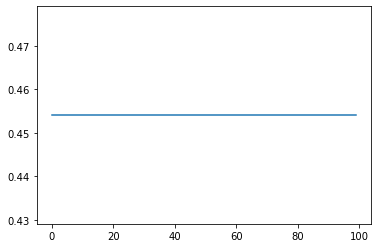

Parameter containing:
tensor([[0., 0., 0., 0., 0., 0.]])
Minimum cost: 0.45409098267555237


In [2202]:
cost_lst = list()
model = LinearRegression(x3.shape[1])

alpha = 0.04 # select an appropriate alpha
lam = 0.001 # select an appropriate lambda
for it in range(100):
    prediction = model(x3)
    cost = mean_squared_error(y, prediction, lam, model.weight)
    print(cost)
    cost_lst.append(cost)
    gradient_descent_step(model, x3, y, prediction, alpha, lam)
display.clear_output(wait=True)
plt.plot(list(range(it+1)), cost_lst)
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

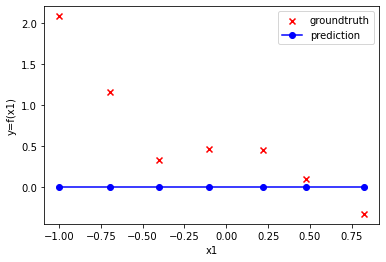

In [2203]:
plt.scatter(x3[:, 0], y, c='red', marker='x', label='groundtruth')
outputs = model(x3)
plt.plot(x3[:, 0], outputs, c='blue', marker='o', label='prediction')
plt.xlabel('x1')
plt.ylabel('y=f(x1)')
plt.legend()
plt.show()